### 🧠 CNN Architecture for MNIST (Grayscale Images)

**Input:**  
`1 × 28 × 28` — *Grayscale image from MNIST*


**1️⃣ Convolutional Block 1:**  
`Conv2d(1, 32, kernel_size=3, padding=1)`  
→ `ReLU`  
→ `MaxPool2d(kernel_size=2, stride=2)`  
→ **Output:** `32 × 14 × 14`

---

**2️⃣ Convolutional Block 2:**  
`Conv2d(32, 64, kernel_size=3, padding=1)`  
→ `ReLU`  
→ `MaxPool2d(kernel_size=2, stride=2)`  
→ **Output:** `64 × 7 × 7`

---

**3️⃣ Fully Connected Layers:**  
- **Flatten** → Shape: `64 × 7 × 7 = 3136`  
- `Linear(3136 → 128)`  
→ `ReLU`  
- `Linear(128 → 10)`  
→ **Output:** *Logits for 10 digit classes (0–9)*

---

✨ Use `LogSoftmax` or `Softmax` afterward depending on your loss function (e.g., `CrossEntropyLoss` expects raw logits).

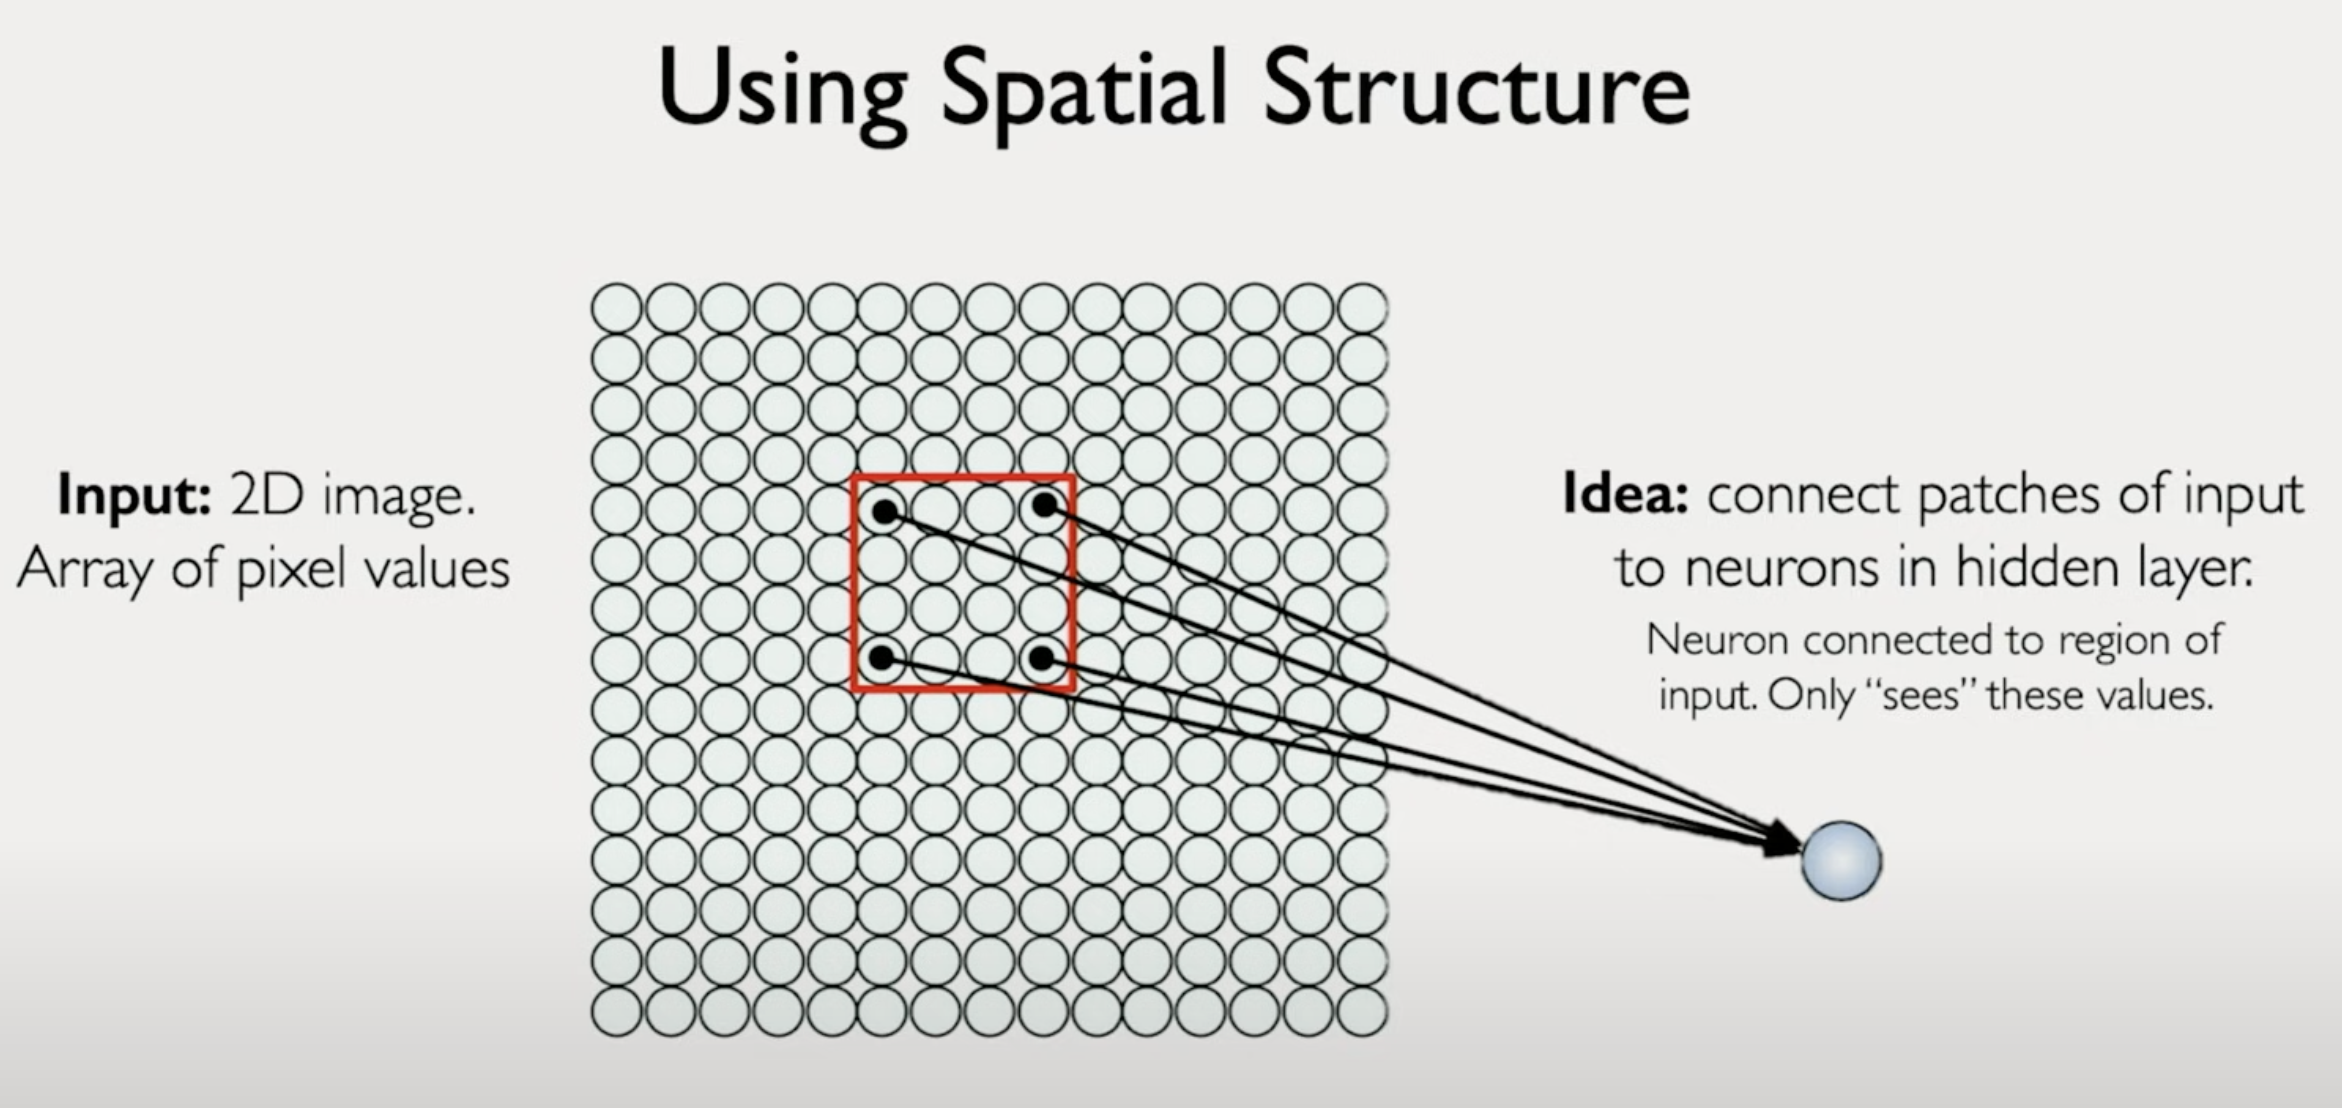

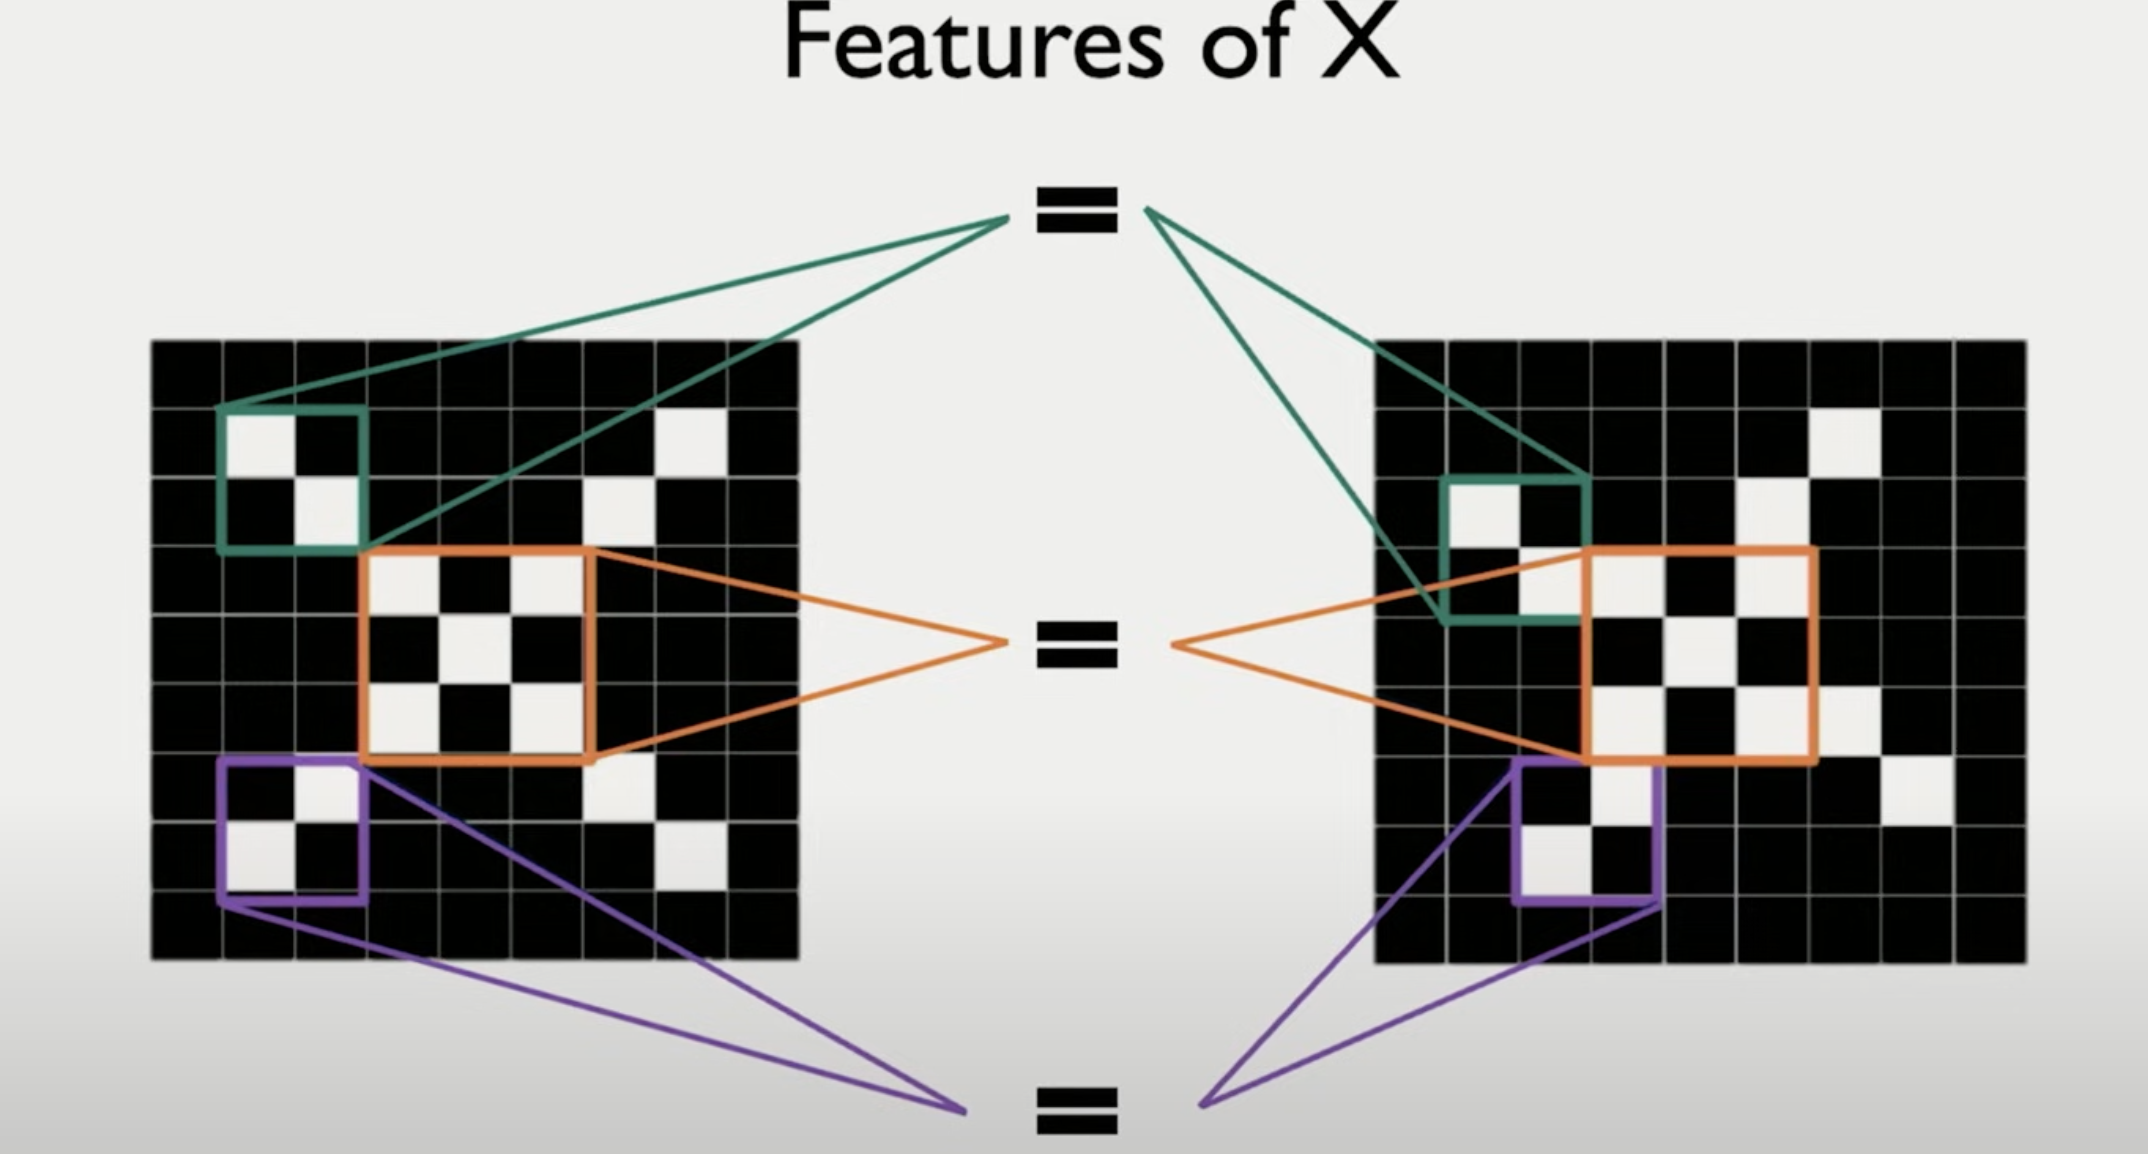

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

100%|███████████████████████████████████████| 9.91M/9.91M [01:02<00:00, 159kB/s]
100%|██████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 74.4kB/s]
100%|███████████████████████████████████████| 1.65M/1.65M [00:11<00:00, 147kB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.14MB/s]


In [4]:
# Define CNN architecture
class CNN(nn.Module):
    '''
    initialising the convolution block with Conv2d --> ReLU --> MaxPool2d
    # Using Sequential to create a small model. When `model` is run,
    # input will first be passed to `Conv2d(1,32)`. The output of
    # `Conv2d(1,32)` will be used as the input to the first
    # `ReLU`; the output of the first `ReLU` will become the input
    # for `Conv2d(20,64,5)`. Finally, the output of
    # `Conv2d(20,64,5)` will be used as input to the second `ReLU`
    '''
    def __init__(self): 
        super(CNN, self).__init__()
        self.conv_block = nn.Sequential(

            # First convolution layer:
            # Takes 1 input channel (grayscale image), outputs 32 feature maps
            # Each kernel is 3x3, and padding=1 keeps the spatial size the same (28x28)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Output: [32, 28, 28]
        
            # ReLU activation adds non-linearity
            nn.ReLU(),
        
            # Max pooling downscales the feature maps by a factor of 2
            # So, from [32, 28, 28] → [32, 14, 14]
            nn.MaxPool2d(2),  # Output: [32, 14, 14]
        
            # Second convolution layer:
            # Takes 32 input channels, outputs 64 feature maps
            # Same kernel and padding, so keeps size before pooling
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: [64, 14, 14]
        
            # Another non-linear activation
            nn.ReLU(),
        
            # Another 2x2 max pooling halves the dimensions again:
            # From [64, 14, 14] → [64, 7, 7]
            nn.MaxPool2d(2)  # Output: [64, 7, 7]
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

## 🧱 Step 0: Input Image

MNIST images are:

* **Grayscale**, so 1 channel (not 3 like RGB)
* **28 x 28 pixels**

So the input tensor to your CNN is:

```
[batch_size, 1, 28, 28]
```

Where:

* `batch_size`: how many images you're passing at once
* `1`: number of channels (1 for grayscale)
* `28x28`: height and width


## 🧠 What is a Feature Map?

A **feature map** is a 2D grid that represents **the activation of a single filter** across the input. It shows **where** and **how strongly** a certain feature (like an edge, curve, texture) appears in the image.

### Key Idea:

* Each convolutional filter learns **one kind of feature**
* Applying that filter across the image creates **one feature map**
* So, if you have **32 filters**, you get **32 feature maps**

> So we are trying to **extract and learn new features** from the image.


## 🧮 Step 1: First Convolution Layer

```python
nn.Conv2d(1, 32, kernel_size=3, padding=1)
```

### Breakdown:

* **Input channels** = 1 (because the MNIST image is grayscale)
* **Output channels** = 32 → this means **we are learning 32 different filters**
* **Kernel size** = 3 → each filter is a 3x3 sliding window
* **Padding = 1** → this adds a border of 1 pixel around the image

### Why padding?

A 3x3 kernel without padding would reduce size:

```
From 28 x 28 → 26 x 26
```

But **with padding=1**, it keeps the size:

```
Output size = same as input size = 28 x 28
```

### So output shape:

```
[batch_size, 32, 28, 28]
```

* 32 feature maps of size 28x28 (one for each filter)


## 🔻 Step 2: MaxPooling

```python
nn.MaxPool2d(kernel_size=2)
```

This **downsamples** the feature maps:

* It takes each 2x2 block and keeps only the **maximum value**
* It **reduces spatial size by half**

### So:

```
From [32, 28, 28] → [32, 14, 14]
```

* Still 32 feature maps
* But each one is smaller

> This helps make the network **faster**, **less overfit**, and **focus on important features**.


## 🧮 Step 3: Second Convolution Layer

```python
nn.Conv2d(32, 64, kernel_size=3, padding=1)
```

### Breakdown:

* **Input channels** = 32 (from the previous layer)
* **Output channels** = 64 → this means we learn 64 new filters
* Each filter still slides over the input and produces a 14x14 feature map
* Again, padding=1 keeps the same size

### So:

```
Input: [batch_size, 32, 14, 14]
Output: [batch_size, 64, 14, 14]
```

Now we have **64 new feature maps**, each representing a different pattern built on top of earlier features.


## 🔻 Step 4: MaxPooling again

```python
nn.MaxPool2d(2)
```

Again reduces spatial size by 2:

```
From [64, 14, 14] → [64, 7, 7]
```


## 🧠 Overall Output Flow:

```text
Input:           [1, 28, 28]   → image
Conv(1 → 32):    [32, 28, 28]
MaxPool(2x2):    [32, 14, 14]
Conv(32 → 64):   [64, 14, 14]
MaxPool(2x2):    [64, 7, 7]    ← final output of conv block
```


## 🧩 Recap of Terms:

| Term                | Meaning                                                                  |
| ------------------- | ------------------------------------------------------------------------ |
| **Feature Map**     | Output of one filter showing where a feature is present in the input     |
| **Filter / Kernel** | A small 3x3 weight matrix that "slides" over the input                   |
| **Channels**        | Number of feature maps in each layer (1 → 32 → 64 in our case)           |
| **Padding**         | Adds extra pixels around the border to maintain size                     |
| **Pooling**         | Reduces the width and height by summarizing regions                      |
| **Stride**          | How far the kernel moves at each step (default = 1 for conv, 2 for pool) |


## 🎯 Visual Analogy:

Imagine you're scanning a photo with a magnifying glass (filter). You slide it over the image and say, "Is there an edge here?" You do this over the whole image.

* Now give 32 different magnifying glasses to check for 32 patterns → you get 32 scanned maps (feature maps)
* Pooling just keeps the strongest signals from these maps and throws away minor details.



In [5]:
# Initialize model
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop
for epoch in range(5):  # 5 epochs
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1602
Epoch 2, Loss: 0.0455
Epoch 3, Loss: 0.0320
Epoch 4, Loss: 0.0228
Epoch 5, Loss: 0.0182


In [7]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.11%
